In [170]:
import os
import sys
import csv
import json
import moment
import pymysql
import datetime

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

%matplotlib inline

## This script can generate the results data file required for plots and tables

Step 1. Set which outcome variable you want to generate data for.

In [171]:
# data_file_name = 'data/pandas_df_v2_2020-04-25.pkl'
# data_file_name = 'data/pandas_df_v3_2020-04-25.pkl'
data_file_name = 'data/pandas_df_v3-1_2020-04-25.pkl'

df = pd.read_pickle(data_file_name)
_version, date_retrieved = data_file_name.split('_df_')[1].split('.')[0].split('_')
print(_version, date_retrieved)

v3-1 2020-04-25


In [176]:
outcome = 'intubated'
days_to = 'days_to_intubation'
outcome_name = 'Intubation'

# outcome = 'died'
# days_to = 'days_to_death'
# outcome_name = 'Survival'

In [177]:
# NaN indicate people who were not covid positive
covidpos = df.dropna()

# remove patients who were intubated before they were diagnosed
covidpos = covidpos[covidpos["days_to_intubation"] >= 0]

# remove patients that died before they were diagnosed
covidpos = covidpos[covidpos["days_to_death"] >= 0]

# remove patients who were intubated or died more than 30 days later
covidpos = covidpos[covidpos["days_to_intubation"] < 90]
covidpos = covidpos[covidpos["days_to_death"] < 90]

# add an age over 65 variable
covidpos['age_over_65'] = (covidpos['age'] >= 65)+1-1

covidpos.describe()

,pat_mrn_id,intubated,days_to_intubation,died,days_to_death,age,sex,macula,compl_def,coagulation,...,refctrl,race_black,race_asian,race_white,race_other,race_declined,eth_hispanic,eth_nonhispanic,eth_declinedother,age_over_65
count,6.397000e+03,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,...,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000
mean,1.095011e+09,0.075191,19.607629,0.085040,19.901516,57.134029,0.497264,0.013756,0.000625,0.184305,...,0.113647,0.221510,0.023136,0.283727,0.280131,0.191496,0.339534,0.369079,0.291387,0.375020
std,1.319922e+08,0.263721,11.330646,0.278963,11.141045,19.877320,0.500032,0.116487,0.025000,0.387763,...,0.317407,0.415295,0.150347,0.450841,0.449098,0.393509,0.473588,0.482593,0.454437,0.484166
min,1.000011e+09,0.000000,0.000000,0.000000,0.000000,0.002738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.004378e+09,0.000000,11.000000,0.000000,11.000000,41.478439,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.009221e+09,0.000000,20.000000,0.000000,20.000000,58.510609,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.200224e+09,0.000000,28.000000,0.000000,28.000000,72.005476,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.400038e+09,1.000000,84.000000,1.000000,83.000000,120.202601,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Iterate through each of the covariates to model and save the summary for later plotting

Covariates
- macula
- compl_def
- coagulation
- hypertension
- type2_diabetes
- obesity
- cad

## Survival Curves

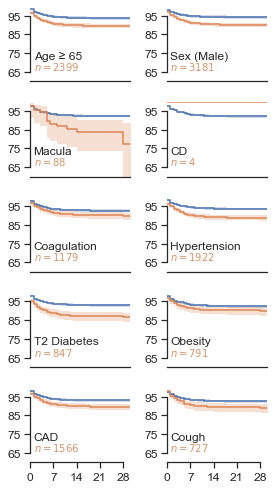

In [178]:
covariates = [
    ('age_over_65', 'Age ≥ 65'),
    ('sex', 'Sex (Male)'),
    ('macula', 'Macula'),
    ('compl_def', 'CD'),
    ('coagulation', 'Coagulation' ),
    ('hypertension', 'Hypertension'),
    ('type2_diabetes', 'T2 Diabetes'),
    ('obesity', 'Obesity'),
    ('cad', 'CAD'),
    ('refctrl', 'Cough'),
]

plt.figure(figsize=(4,7))

for i,(covar, name) in enumerate(covariates):
    sns.set(style='ticks', font_scale=1.1)
    
    plt.subplot(5,2,i+1)
    
    kmf = KaplanMeierFitter()
    
    ix = (covidpos[covar] == 1)
    T, E = covidpos[days_to], covidpos[outcome]
    kmf_others = kmf.fit(T[~ix], E[~ix], label='Others')
    ax1 = kmf_others.plot(ci_no_lines=True)
    
    
    kmf_condition = kmf.fit(T[ix], E[ix], label=name)
    ax2 = kmf_condition.plot(ci_no_lines=True)
    
    plt.yticks([0.65, 0.75, 0.85, 0.95], ['65', '75', '85', '95'])
    
    if i >= 8:
        plt.xlabel('')
        plt.xticks([0, 7, 14, 21, 28])
    else:
        plt.xlabel('')
        plt.xticks([])
        ax1.axes.get_xaxis().set_visible(False)
        ax2.axes.get_xaxis().set_visible(False)
#         plt.tick_params(axis='x', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    
    plt.xlim(0,30)
    plt.ylim(0.60, 1)
    
    plt.text(1, 0.72, name, fontsize=12)
    plt.text(1, 0.66, '$n = %d$' % sum(ix), fontsize=10, color='#D5936B')
    
    plt.legend().remove()

    sns.despine(trim=True)

plt.tight_layout()

plt.savefig('figures/survival_curves_%s_%s_%s.pdf' % (outcome, _version, date_retrieved))